In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
diamond_df = pd.read_csv('diamonds.csv', index_col=0)
diamond_df.head(20)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [3]:
diamond_df.shape

(53940, 10)

In [4]:
diamond_df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [5]:
diamond_df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [6]:
# Encode the ordinal categorical variable 'cut'
cut_mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
diamond_df.cut = diamond_df.cut.map(cut_mapping)

In [7]:
# Encoding the ordinal categorical variable 'color'
color_mapping = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
diamond_df.color = diamond_df.color.map(color_mapping)

In [8]:
# Encoding the ordinal cateogircal variable 'clarity'
clarity_mapping = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
diamond_df.clarity = diamond_df.clarity.map(clarity_mapping)

In [9]:
diamond_df = diamond_df.drop(diamond_df[diamond_df["x"]==0].index)
diamond_df = diamond_df.drop(diamond_df[diamond_df["y"]==0].index)
diamond_df = diamond_df.drop(diamond_df[diamond_df["z"]==0].index)

In [10]:
diamond_df = diamond_df[diamond_df['depth'] < diamond_df['depth'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['table'] < diamond_df['table'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['x'] < diamond_df['x'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['y'] < diamond_df['y'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['z'] < diamond_df['z'].quantile(0.99)]

In [11]:
diamond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
2,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
4,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
5,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75
6,0.24,2,0,5,62.8,57.0,336,3.94,3.96,2.48


<ipython-input-12-3823f6fbda28>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(diamond_df.corr(), dtype=np.bool))


<AxesSubplot:>

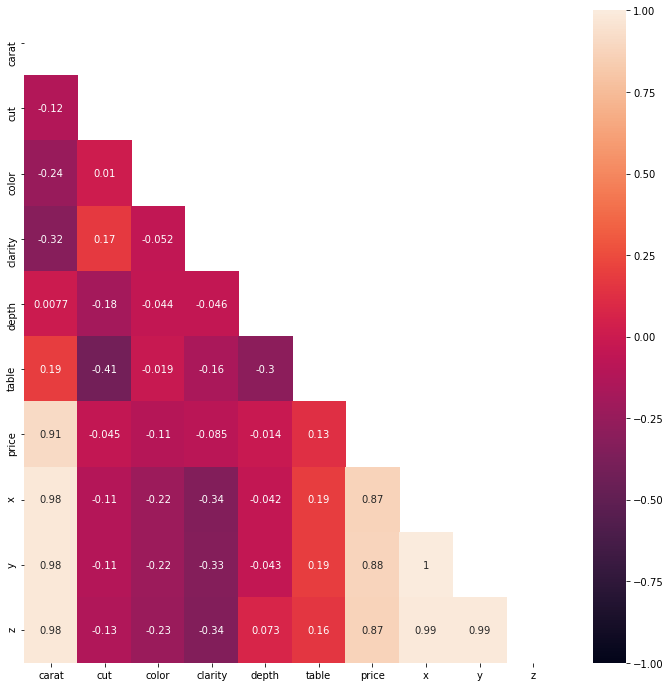

In [12]:
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(diamond_df.corr(), dtype=np.bool))
sns.heatmap(diamond_df.corr(),vmin=-1, vmax=1, annot=True, mask=mask)

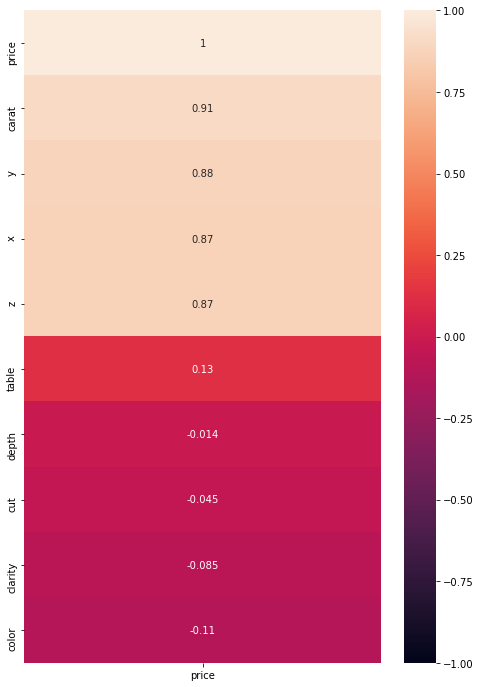

In [13]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(diamond_df.corr()[['price']].sort_values(by='price',ascending=False),vmin=-1, vmax=1, annot=True)

In [14]:
model_df = diamond_df.copy()
X = model_df.drop(['price'], axis=1)
y = model_df['price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

In [15]:
xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.0001, 0.001, .01],
              'max_depth': [3, 5, 7],
              'min_child_weight': [3,5,7],
              'subsample': [0.1,0.5,1.0],
              'colsample_bytree': [0.1, 0.5, 1.0],
              'n_estimators': [500]}

In [16]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=0)

xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.1, 0.5, 1.0],
                         'learning_rate': [0.0001, 0.001, 0.01],
                         'max_depth': [3, 5, 7], 'min_child_weight': [3, 5, 7],
                         'n_estimators': [500],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.1, 0.5, 1.0]})

In [17]:
xgb_cv = (xgb_grid.best_estimator_)

In [18]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [19]:
fit_model = xgb_cv.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric='mae',
    early_stopping_rounds=50,
    verbose=False)

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [20]:
print("MAE:", mean_absolute_error(y_val, fit_model.predict(X_val)))
print("MSE:", mean_squared_error(y_val, fit_model.predict(X_val)))
print("R2:", r2_score(y_val, fit_model.predict(X_val)))

MAE: 235.76115356600496
MSE: 196555.23133762396
R2: 0.9835076894068906


In [21]:
fit_model.save_model('xgb_model.json')